In [1]:
import os
os.chdir("/home/studio-lab-user/sagemaker-studiolab-notebooks/AI-OT-24/Reinforcement-Learning-Stock-Porfolio-Managment")
!pip install -q -r requirements.txt
import sys
sys.path.append('./utils')
from trading_functions import *
# Core Libraries
import os
import sys
import time
import datetime
import warnings
import itertools
#warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = info, 2 = warnings, 3 = errors

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# Financial Data
import yfinance as yf
import quantstats as qs
import ta

# Machine Learning - Supervised Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Machine Learning - Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy

# Reinforcement Learning and Environments
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import A2C, DDPG, DQN, HER, PPO, SAC, TD3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import (
    EvalCallback, StopTrainingOnRewardThreshold, StopTrainingOnNoModelImprovement
)
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecCheckNan, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from sb3_contrib import ARS, MaskablePPO, RecurrentPPO, QRDQN, TRPO

# Imitation Learning
from imitation.algorithms import bc
from imitation.testing.reward_improvement import is_significant_reward_improvement
from imitation.data.types import Transitions

# Interactive Brokers API
from ib_insync import *

from typing import Callable

from collections import Counter

clear_output()


In [11]:
# Define constants
SEED = 1
history_length = 5#[1, 2, 3, 4, 5, 6, 7, 8, 10, 16]
reward_type = 'LNR'
stocks = ['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'TSLA']
start_date = '2021-01-01'
end_date = '2023-06-30'
n_envs = 8
n_steps = 16
total_timesteps = 50_000
batch_size = 32
learning_rate = 0.001
ent_coef = 0.05
log_interval = 1_000
eval_freq = 1_000
model_name= 'A2C'

current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_save_dir = None #f'./models/model_{current_date}'
log_dir = None #f'./logs/log_{current_date}'


# Training environment
env, env_fn, date_interval, scalers, df, df_unscaled = create_env(
    5, reward_type, start_date, end_date, stocks, True, []
)

In [3]:
list(df_unscaled.columns.levels[0])

['Close',
 'High',
 'Low',
 'Open',
 'Volume',
 'week_day_number',
 '5MA',
 '10MA',
 '15MA',
 '20MA',
 'Daily_Return',
 'Bollinger_High',
 'Bollinger_Low',
 'RSI',
 'MACD',
 'MACD_Signal',
 '12EMA',
 '26EMA',
 'OBV']

In [4]:
import pandas as pd
import numpy as np

# Define the number of iterations
n = 5  # Replace this with your desired number of iterations


for i in range(1):
    print(f"Iteration {i + 1}")

    # Extract the existing levels and ensure the order matches the required levels
    price_levels = list(df_unscaled.columns.levels[0])
    ticker_levels = list(df_unscaled.columns.levels[1]) + ['NotFound']  # Add 'NotFound'

    # Create the full MultiIndex with the new 'NotFound' ticker
    new_columns = pd.MultiIndex.from_product(
        [price_levels, ticker_levels],
        names=df_unscaled.columns.names
    )

    # Create a new DataFrame with zeros for the entire expanded MultiIndex
    expanded_data = pd.DataFrame(
        0,  # Fill with zeros
        index=df_unscaled.index,
        columns=new_columns
    )

    # Update the expanded DataFrame with the original data
    expanded_data[df_unscaled.columns] = df_unscaled

    # Display the resulting DataFrame
    print(expanded_data)
    df_unscaled = expanded_data



Iteration 1
Price            Close                                                 \
Ticker            AAPL        AMZN        META        MSFT       NVDA   
Date                                                                    
2021-01-04  126.544235  159.331497  267.916565  210.423096  13.080301   
2021-01-05  128.108765  160.925507  269.938873  210.626099  13.370811   
2021-01-06  123.796432  156.919006  262.308014  205.164719  12.582565   
2021-01-07  128.020767  158.108002  267.717316  211.003036  13.310218   
2021-01-08  129.125778  159.134995  266.551788  212.288666  13.243138   
...                ...         ...         ...         ...        ...   
2023-06-23  185.275299  129.330002  287.631287  331.158630  42.189850   
2023-06-26  183.875900  127.330002  277.410309  324.812653  40.613564   
2023-06-27  186.644913  129.179993  285.957672  330.713837  41.857002   
2023-06-28  187.825943  129.039993  284.204376  331.979095  41.098347   
2023-06-29  188.163391  127.900002  280

In [5]:
df_unscaled.iloc[0].index.levels

FrozenList([['10MA', '12EMA', '15MA', '20MA', '26EMA', '5MA', 'Bollinger_High', 'Bollinger_Low', 'Close', 'Daily_Return', 'High', 'Low', 'MACD', 'MACD_Signal', 'OBV', 'Open', 'RSI', 'Volume', 'week_day_number'], ['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'NotFound', 'TSLA']])

In [14]:
env = TradingEnvUniqueMultiple(df_unscaled, history_length, reward_type)
check_env(env)

Evaluating model: A2C


/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


A2C Train Mean reward: -60.15 ± 0.00
A2C
Total return of portfolio: 6.58%


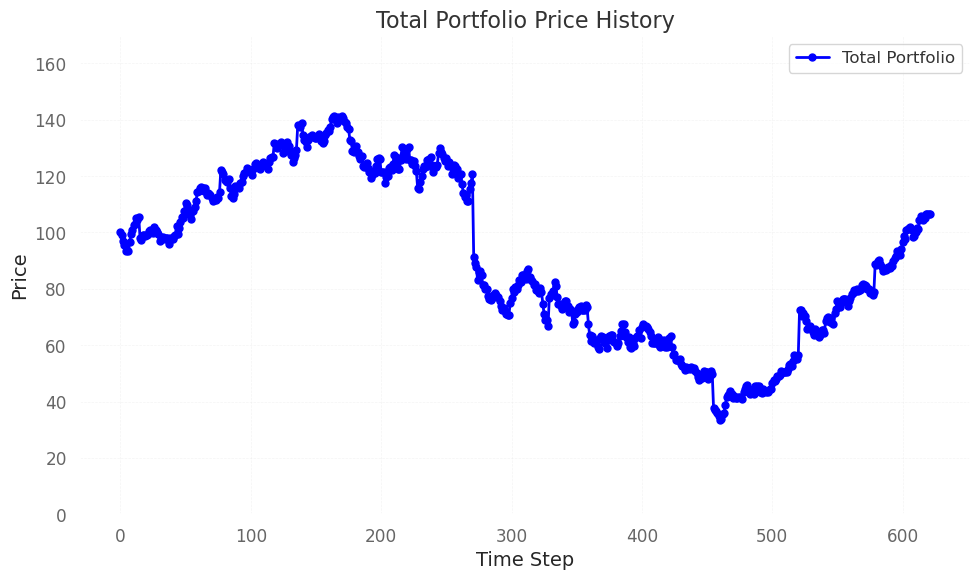

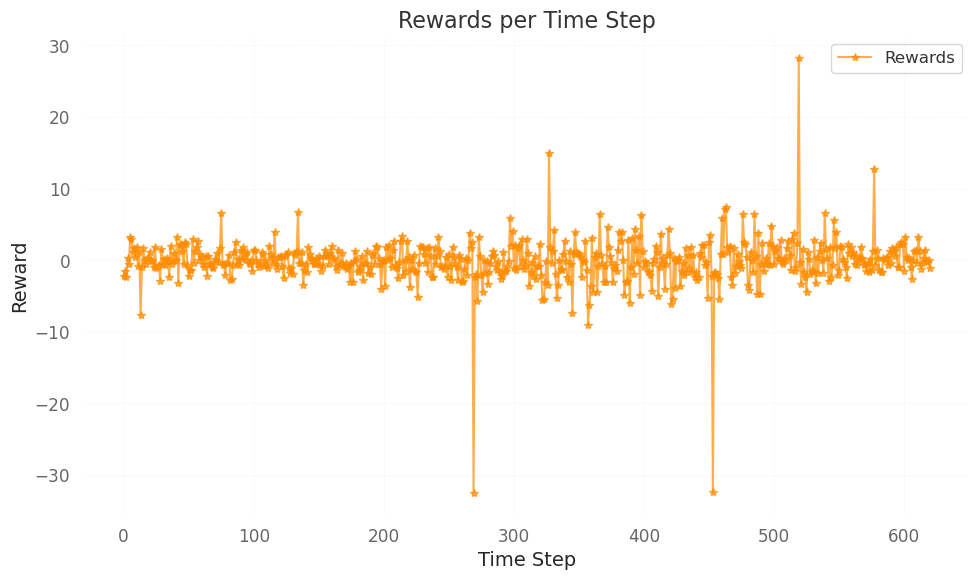

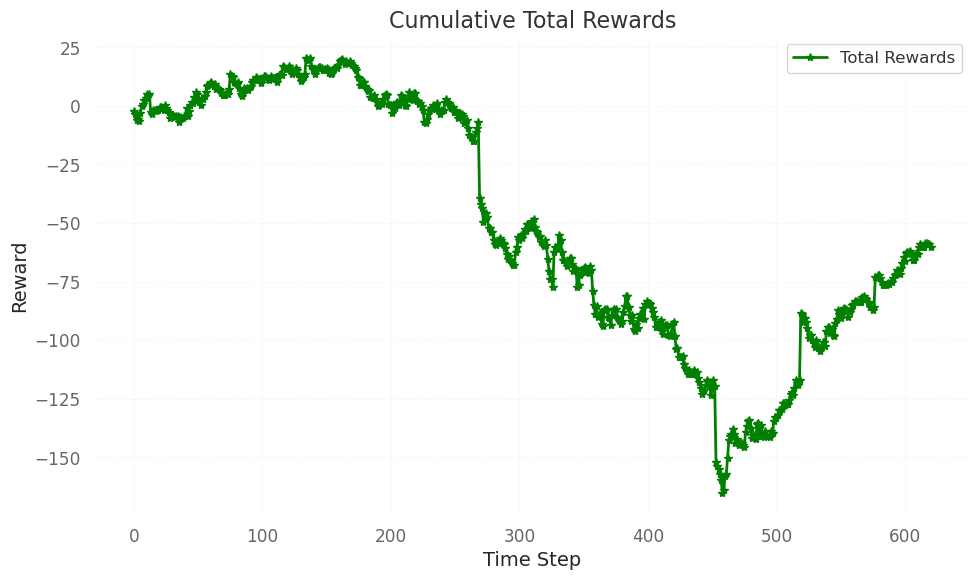

Total rewards: -60.15150588046753


([array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  array(2),
  ar

In [16]:
model = A2C('MlpPolicy', 
                    env,
                    learning_rate=0.02,
                    n_steps=16,
                    gamma=0.99,
                    gae_lambda=1.0,
                    ent_coef=0.05,
                    vf_coef=0.5,
                    max_grad_norm=0.5,
                    rms_prop_eps=1e-05,
                    use_rms_prop=True,
                    use_sde=False,
                    sde_sample_freq=-1,
                    rollout_buffer_class=None,
                    rollout_buffer_kwargs=None,
                    normalize_advantage=False,
                    stats_window_size=100,
                    tensorboard_log=None,
                    policy_kwargs=None,
                    verbose=0,
                    seed=0,
                    device='auto',
                    _init_setup_model=True)

model.learn(
            total_timesteps=10_000,
            progress_bar=False,
            log_interval=1_000,
            tb_log_name=f"A2C",
            reset_num_timesteps=True,
            callback=None
        )
model_name = 'A2C'
# Evaluate the model on training and test environments
print(f"Evaluating model: {model_name}")

# Training evaluation
mean_train_reward, std_train_reward = evaluate_policy(
    model.policy if hasattr(model, 'policy') else model,
    env,
    n_eval_episodes=1,
    deterministic=True
)
print(f"{model_name} Train Mean reward: {mean_train_reward:.2f} ± {std_train_reward:.2f}")
evaluate_model(env, model, model_name, 1, has_policy=True) if hasattr(model, 'policy') else evaluate_model(env, model, model_name, 1, has_policy=False)